In [1]:
%matplotlib qt

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import ot
import ot.gpu

In [4]:
import os
os.listdir()

['distances.ipynb', '.ipynb_checkpoints', 'distances.py']

In [5]:
import sys
sys.path.append('..')

from external.structural_losses.tf_approxmatch import approx_match, match_cost
from external.sampling.tf_sampling import farthest_point_sample, prob_sample

External Losses (Chamfer-EMD) were not loaded.
/home/betairya/RP_ML/NNParticles/external/structural_losses


In [6]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib import pyplot as plt
import ot.plot
from sklearn.datasets import make_moons, make_circles

In [7]:
def get_ref(n):
    X, y = make_moons(n_samples = n * 2, shuffle = False, noise = 0.1)
    ref = X[:n] # Reference samples
    return ref, X[n:]

def get_rec(n, good_ratio):
    good_count = int(n * good_ratio)
    bad_count  = n - good_count

    good_rec = np.random.normal([0.0, 0.0], [0.3, 0.3], size = (good_count, 2))
    bad_rec  = np.random.normal([1.0,-1.0], [1.0, 0.1], size = ( bad_count, 2))
    rec = np.concatenate([good_rec, bad_rec], axis = 0)
    
    return rec

In [38]:
n = 512
ref, ref_2 = get_ref(n)
rec_1 = get_rec(n, 0.2)
rec_2 = get_rec(n, 1.0)
rec = get_rec(n, 0.5)

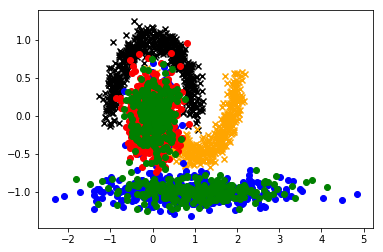

In [39]:
plt.figure(-2)
plt.scatter(ref[:, 0], ref[:, 1], color = 'black', marker = 'x')
plt.scatter(ref_2[:, 0], ref_2[:, 1], color = 'orange', marker = 'x')
plt.scatter(rec_1[:, 0], rec_1[:, 1], color = 'blue')
plt.scatter(rec_2[:, 0], rec_2[:, 1], color = 'red')
plt.scatter(rec[:, 0], rec[:, 1], color = 'green')

In [10]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [11]:
def chamfer(n, ref, rec):
    plan = np.zeros((n, n))
    dist = np.sqrt(np.sum(np.square(np.reshape(ref, (1, n, 2)) - np.reshape(rec, (n, 1, 2))), axis = -1))
#     plt.figure(1243)
#     plt.imshow(dist)
#     np.fill_diagonal(dist, 10.0)
    
    min_ref = np.argmin(dist, axis = 1)
    min_rec = np.argmin(dist, axis = 0)
    
    for i, j in zip(range(n), min_rec):
        plan[i, j] = 1.0
        pass
        
    for i, j in zip(min_ref, range(n)):
        plan[i, j] = 1.0
        pass
    
    plan /= plan.sum()
    
#     plt.imshow(plan)
    
    return plan, (plan * dist).sum()

def sinkhorn(n, ref, rec):
    dist = np.sqrt(np.sum(np.square(np.reshape(ref, (1, n, 2)) - np.reshape(rec, (n, 1, 2))), axis = -1))
    a = np.ones((n,)) / n
    b = np.ones((n,)) / n
    plan = ot.sinkhorn(a, b, dist / dist.max(), 3e-2)
#     plt.imshow(plan)
    return plan, (plan * dist).sum()

def exactEMD(n, ref, rec):
    dist = ot.dist(ref, rec)
    a = np.ones((n,)) / n
    b = np.ones((n,)) / n
    plan = ot.emd(a, b, dist)
#     plt.imshow(plan)
#     print(plan.sum())
#     plt.figure(-1)
#     plt.imshow(dist)
#     plt.figure(100)
#     plt.imshow(plan)
    return plan, (plan * dist).sum()

def aEMD(n, ref, rec):
    ref_3d = np.zeros((1, n, 3))
    rec_3d = np.zeros((1, n, 3))
    ref_3d[0, :, 0:2] = ref
    rec_3d[0, :, 0:2] = rec
    
    ph_ref = tf.placeholder(tf.float32, [1, n, 3])
    ph_rec = tf.placeholder(tf.float32, [1, n, 3])
    match = approx_match(ph_ref, ph_rec)
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    
    plan = sess.run(match, feed_dict = {ph_ref: ref_3d, ph_rec: rec_3d})[0, :, :]
    plan /= plan.sum()
    print(plan.sum())
#     plt.figure(12387)
#     plt.imshow(plan)
    
    dist = np.sqrt(np.sum(np.square(np.reshape(ref, (1, n, 2)) - np.reshape(rec, (n, 1, 2))), axis = -1))
        
    return plan, (plan * dist).sum()

1.0
1.0
1.0


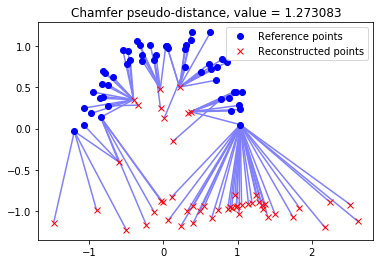

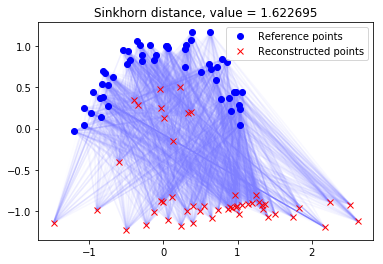

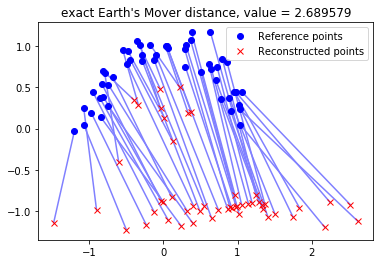

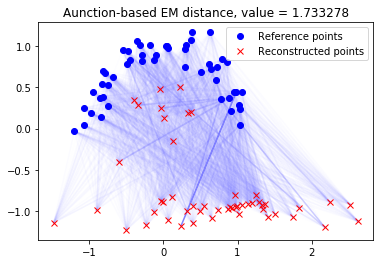

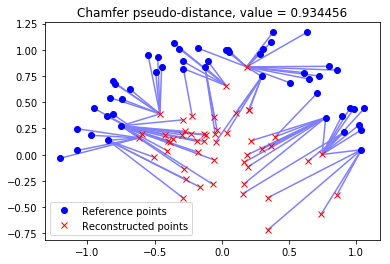

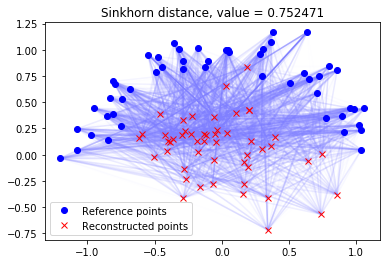

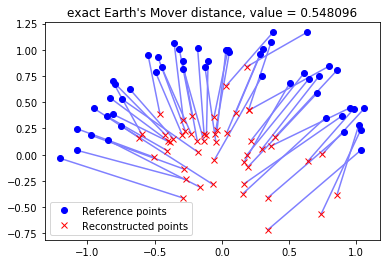

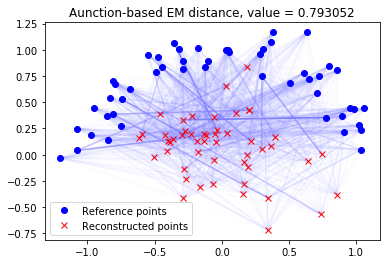

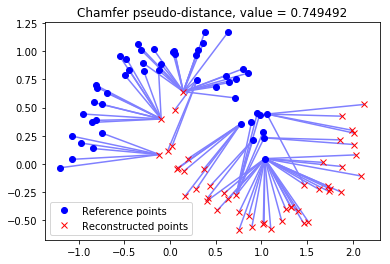

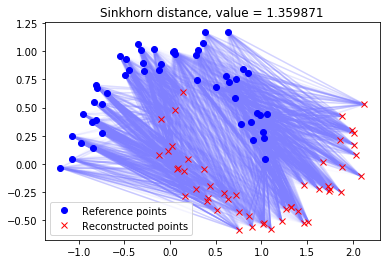

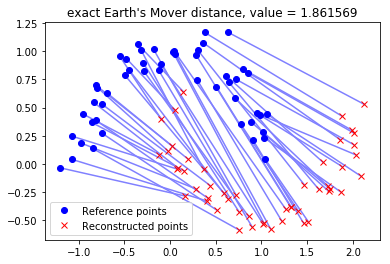

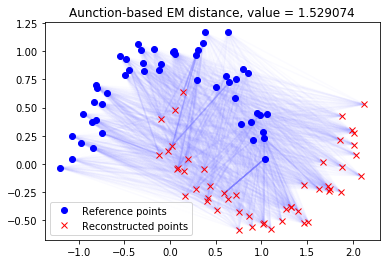

In [12]:
# recs = [rec_1, rec_2, rec]
recs = [rec_1, rec_2, ref_2]
fcnt = 0
for rc in recs:
    pds = [chamfer(n, ref, rc), sinkhorn(n, ref, rc), exactEMD(n, ref, rc), aEMD(n, ref, rc)]
    name = ['Chamfer pseudo-', 'Sinkhorn ', 'exact Earth\'s Mover ', 'Aunction-based EM ']

    for p in range(len(pds)):
        plan, dist = pds[p]
        title = name[p] + 'distance, value = ' + '%6f' % dist
        
        pl.figure(fcnt)
        fcnt += 1
        ot.plot.plot2D_samples_mat(ref, rc, plan, color = [.5, .5, 1], thr = 1e-3)
        pl.plot(ref[:, 0], ref[:, 1], 'ob', label = 'Reference points')
        pl.plot(rc[:, 0],  rc[:, 1],  'xr', label = 'Reconstructed points')
        pl.legend(loc = 0)
        pl.title(title)

1
512
512
1549
0.343249 seconds used


KeyboardInterrupt: 

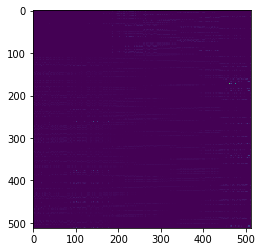

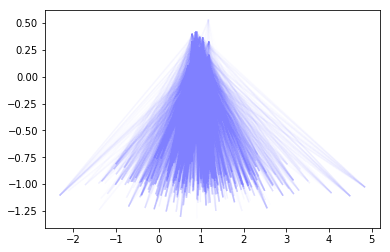

In [41]:
import time

# M: [bs, Nr, Nc]
def tf_Sinkhorn_kernel(M, reg, dtype):
#     eplison = -100
    eplison = 0
    
    bs = int(M.get_shape()[0])
    Nr = int(M.get_shape()[1])
    Nc = int(M.get_shape()[2])
    
    print(bs)
    print(Nr)
    print(Nc)
    
    r  = tf.ones([Nr], dtype) / Nr
    c  = 1.0 / Nc
    
    assert Nr == Nc
    
    lmbd = 1.0 / reg
    K    = tf.exp(-lmbd * M)
    u    = tf.ones([bs, Nr], dtype) / Nr
    K2   = tf.matmul(tf.broadcast_to(tf.reshape(tf.linalg.diag(1.0 / r), [1, Nr, Nr]), [bs, Nr, Nr]), K)
    
    def cond(i, u, u_prev):
        return tf.logical_and(tf.less(i, 5000), tf.greater(tf.abs(tf.reduce_mean(u - u_prev)), 1e-8))
#         return tf.less(i, 5000)
    
    # u:  bs, Nr, 1
    # c:   1
    # K:  bs, Nr, Nc
    # K2: bs, Nr, Nc
    i = tf.constant(0)
    u = tf.reshape(u, [bs, Nr, 1])
    def body(i, u, u_prev):
        u_prev = u
        u = 1.0 / (tf.matmul(K2, c / (tf.matmul(K, u, adjoint_a = True))) + eplison)
        i = i + 1
        return [i, u, u_prev]
    
    total_idx, u_final, _ = tf.while_loop(cond, body, [i, u, tf.zeros_like(u)], back_prop = False)
    
    u = u_final
    v = c / (tf.matmul(K, u, adjoint_a = True)) # [bs, Nc, 1]
    plan = u * K * tf.reshape(v, [bs, 1, Nc])
    
    return total_idx, plan

def tf_Sinkhorn(n, ref, rec):
    
    dtype = tf.float64
    
    dist = np.sqrt(np.sum(np.square(np.reshape(ref, (1, n, 2)) - np.reshape(rec, (n, 1, 2))), axis = -1))
    dist = np.reshape(dist, [1, n, n])
    
    ph_M = tf.placeholder(dtype, [1, n, n])
#     bc_ph_M = tf.broadcast_to(ph_M, [16, n, n])
    bc_ph_M = tf.broadcast_to(ph_M, [1, n, n])
    
    tx, match = tf_Sinkhorn_kernel((bc_ph_M / tf.reduce_max(bc_ph_M)) * 1.0, 1.5e-3, dtype)
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    
    tidx, plan = sess.run([tx, match], feed_dict = {ph_M: dist})
    plan = plan[0]
    print(tidx)
#     print(plan.sum(axis = 1))
    return plan, (plan * dist).sum()

rc = rec_1

start = time.time()
plan, dist = tf_Sinkhorn(n, ref, rc)
end = time.time()
print('%f seconds used' % (end - start))

title = 'TF Sinkhorn distance, value = ' + '%6f' % dist

pl.figure(12556)
pl.imshow(plan)

pl.figure(12389)
ot.plot.plot2D_samples_mat(ref, rc, plan, color = [.5, .5, 1], thr = 1e-3)
pl.plot(ref[:, 0], ref[:, 1], 'ob', label = 'Reference points')
pl.plot(rc[:, 0],  rc[:, 1],  'xr', label = 'Reconstructed points')
pl.legend(loc = 0)
pl.title(title)

1.0
1
512
512
2458


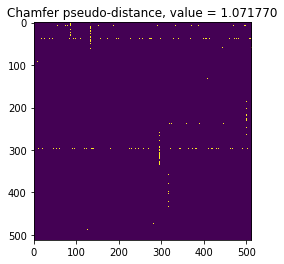

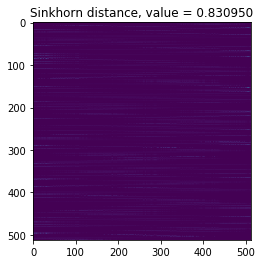

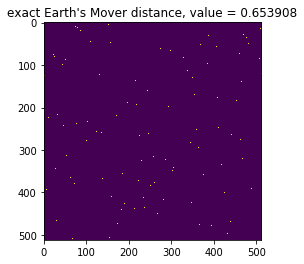

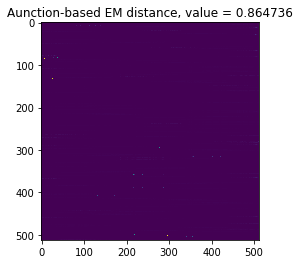

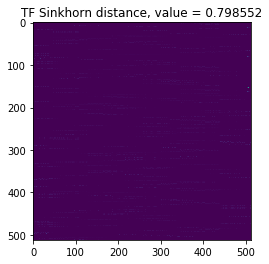

In [43]:
# recs = [rec_1, rec_2, rec]
recs = [rec_2]
fcnt = 0
for rc in recs:
    pds = [chamfer(n, ref, rc), sinkhorn(n, ref, rc), exactEMD(n, ref, rc), aEMD(n, ref, rc), tf_Sinkhorn(n, ref, rc)]
    name = ['Chamfer pseudo-', 'Sinkhorn ', 'exact Earth\'s Mover ', 'Aunction-based EM ', 'TF Sinkhorn ']

    for p in range(len(pds)):
        plan, dist = pds[p]
        title = name[p] + 'distance, value = ' + '%6f' % dist
        
        pl.figure(fcnt)
        fcnt += 1
        pl.imshow(plan / plan.max())
#         ot.plot.plot2D_samples_mat(ref, rc, plan, color = [.5, .5, 1], thr = 1e-3)
#         pl.plot(ref[:, 0], ref[:, 1], 'ob', label = 'Reference points')
#         pl.plot(rc[:, 0],  rc[:, 1],  'xr', label = 'Reconstructed points')
#         pl.legend(loc = 0)
        pl.title(title)